# Task $n^\circ$ 1 
To correctly run the script <code>pylatexenc</code>, <code>qiskit</code>, <code>ipynb</code> have to be installed. 


## Import the libraries:
(tools.ipynb has to be in the same folder as adder)

In [55]:
from qiskit import QuantumCircuit, Aer, execute, QuantumRegister
import qiskit.quantum_info as qi
import math
import numpy as np
from qiskit.visualization import plot_histogram
from ipynb.fs.full.tools import adder, qft_1, count, w

## Insert the set of numbers and the sum we want to find:

In [ ]:
numbers = [5,7,8,9,1]
solution = 16

## Initialise the circuit:

In [61]:
# We filter numbers bigger than the final solution we want
numbers = list(filter(lambda x: x <= solution, numbers))

# 
sum_num = sum(numbers)
bit_sum = int(np.log2(sum_num)) + 1
n = len(numbers) + bit_sum

qr = QuantumRegister(len(numbers), 'q')
qa = QuantumRegister(bit_sum, 'a')
qc = QuantumCircuit(qr, qa)

In [62]:
#Choose the set of combination you want to try:

#All the possible combinations:
qc.h(range(len(numbers)))

#Only one item at a time: eg: [5,7,8,9,1], 9 -> 9
#qc.w_state(range(len(numbers)))

#All items but not 1: eg: [2,9,1,3,5], 11 -> 2+9+1+3+5
#qc.w_state(range(len(numbers)))
#qc.x(range(len(numbers)))


qc.h(range(len(numbers), bit_sum + len(numbers)))
qc.adder(bit_sum, numbers)
qc.qft_1(range(len(numbers),len(numbers)+bit_sum))

In [63]:
counts = count(qc)
filtered = [(k[bit_sum:], v) for k, v in counts.items() if k[:bit_sum] == ('{0:0'+str(bit_sum)+'b}').format(solution)]

In [64]:
print('Solutions:')
for sol in filtered:
    combination = []
    for i in range(len(numbers)):
        if sol[0][i] == '1':
            combination.append(str(numbers[::-1][i]))
    print('> ', '+'.join(combination))

Solutions:
>  1+8


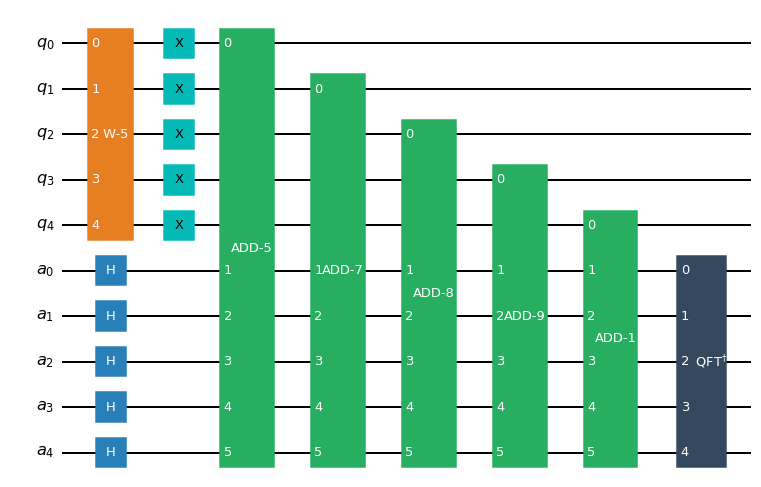

In [60]:
style = {'displaycolor': {'qtf-1':   ('#34495E', '#FFFFFF'),
                          (' W-'+str(len(numbers))+' '):   ('#E67E22', '#FFFFFF'),
                          'h':   ('#2980B9', '#FFFFFF'),},
         'displaytext' : {'qtf-1': "\quad \\mathrm{QFT}^{\dagger}."},
         'gatefacecolor' : '#27AE60',
         'gatetextcolor' : '#FFFFFF'}
qc.draw(output='mpl', style=style)

In [71]:
import qiskit.tools.jupyter
%qiskit_version_table